Congratulations on reaching the assignment stage!

On this assignment you will work with a dataset of real life taxi rides and will prepare a basic prediction model, just like we do at Autofleet.

Instructions will be provided as you progress through this notebook.

Please try to be as detailed and descriptive as possible so that we understand your
thought process.

In [1]:
%matplotlib inline
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error
import numpy as np 

## Load Data

In [2]:
df_rides = pd.read_csv('rides.csv')
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


## Data Exploration

In [3]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'rides'})
df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()


,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


### Task #1

Plot the rides overtime on a daily level. 
Is there any trend?

### Task #1 - Answer

In [4]:
from utils import plot_values_on_daily_level

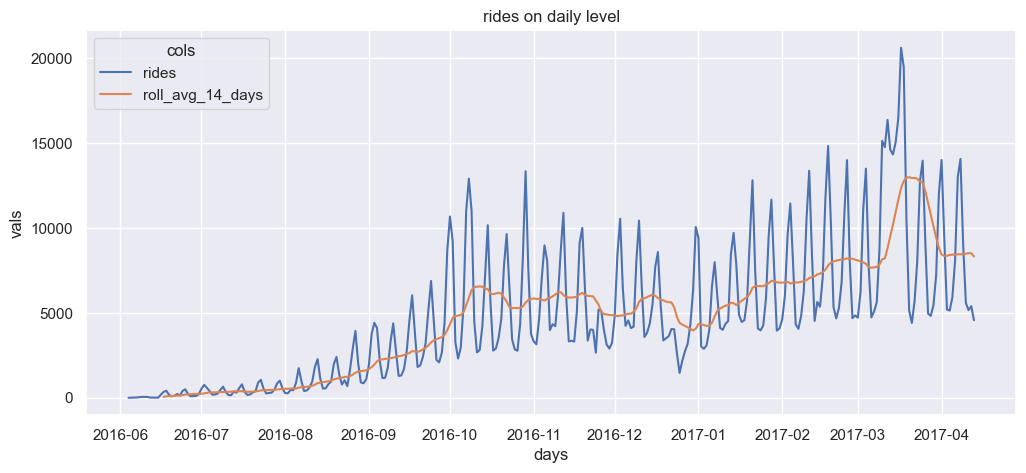

In [5]:
df_daily_rides = plot_values_on_daily_level(df = df_hourly_rides,
                                            value_column = 'rides', 
                                            time_column = "created_on_hour",
                                            roll_avg_days = 14)

Yes, it appears there is a trend and also seasonality. 
1. First, there is a clear periodicity shown by the amplitudes within intervals of weeks.
2. Second, there is also a clear trend of increasing usage with an interval of almost one year.The moving average line is showing this trend clearly.

### Task #2

Plot a ride distance histogram.
What is the distribution? is it normal?

### Task #2 - Answer

Given that the data is quite large, let's take several samples for the histogram and visually check if the distribution significantly changes between samples. 
Afterwards, let's run the Kolmogorov-Smirnov test to test the null hypothesis that the data is not normally distributed.

In [6]:
from utils import sample_and_plot_histogram

In [7]:
# sample_and_plot_histogram(df = df_rides, 
#                           per_of_sample  = 0.01,
#                           value_columns = "distance_travelled",
#                           number_of_samples = 20)

None of the different samples appear to be normal. The main reason is that they do not exhibit properties of a normal distribution, the most obvious being the lack of symmetry. 
Let's test the hypothesis that the data comes from a normal distribution using the Kolmogorov-Smirnov test.

In [8]:
scipy.stats.kstest(df_rides.distance_travelled.dropna(how='all'),
                   scipy.stats.norm.cdf)

KstestResult(statistic=0.9999020691530339, pvalue=0.0, statistic_location=4.0, statistic_sign=-1)

$P_{value} = 0$ indicating that we must reject the null hypothesis that the distance traveled follows a normal distribution.

## Preprocessing

In [9]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


### Task #3

You have time features in the df_times dataframe. 
Merge this dataframe with the hourly rides dataframe, so you can use those features later.

### Task #3 - Answer

In order to prevent from issues when joining the data lets run several queries 



In [10]:
from utils import queries_before_join

In [11]:
queries_before_join(df_times = df_times, 
                    df_hourly_rides = df_hourly_rides)

Number of unique time points in df_times: 7531

Number of unique time points in df_hourly_rides : 7296

Duplicates in `df_times`: 0

How many out of df_hourly_rides is in df_times ?  7296

Out of the df_times observations, what is the distribution of the times that do not appear in the df_hourly_rides?
 2016-06    202
2016-07     24
2016-08      7
2016-09      1
2017-03      1
Freq: M, Name: datetime, dtype: int64


As it is evident from the above, the df_time object includes all time points present in df_hourly_rides and more. Furthermore, the time points that exist in df_time but not in df_hourly_rides are spread out across months, but the majority of these measurements are related to the beginning of the data. Therefore, let's perform a left join on df_hourly_rides and df_time.

In [12]:
df_hourly_times_rides = pd.merge(df_times, 
                                 df_hourly_rides, 
                                 left_on='datetime', 
                                 right_on='created_on_hour',
                                 how="left")

# Test unchanged df_hourly_rides shape
df_hourly_times_rides.shape

(7531, 12)

After the join its clear from the belloe the across the data there is missing `rides` points.

We would need to target that issue over the modeling part.

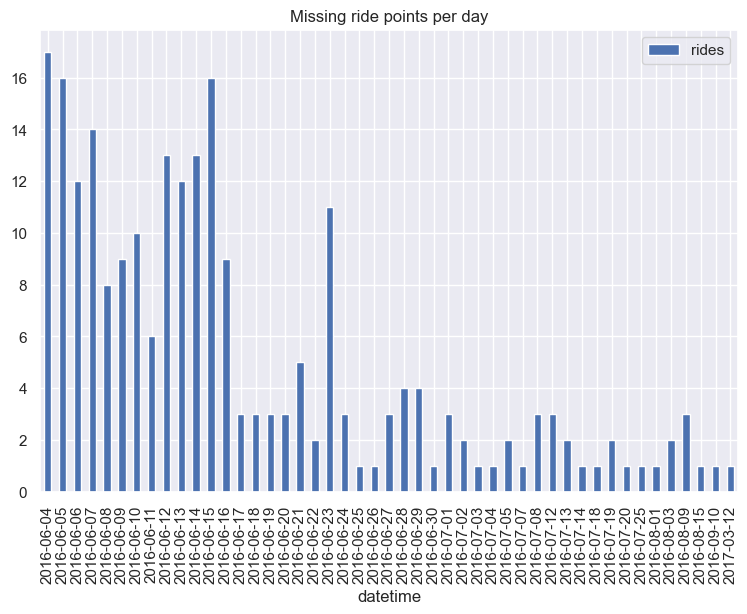

In [609]:
dd = df_hourly_times_rides[df_hourly_times_rides.rides.isna()]
dd.rides = 1
dd.groupby([dd["datetime"].dt.date]).sum().reset_index().plot.bar(x="datetime",
                                                                  y = "rides",
                                                                  title= 'Missing ride points per day');

### Task #4

We would like to add a lag feature, which retrieves the amount of rides taken at the same exact hour last week. 
Please implement this feature.
What is the correlation between current and last week's rides?

### Task #4 - Answer

In [13]:
from utils import add_time_unit_lag

In [14]:
df_hourly_times_rides = add_time_unit_lag(df = df_hourly_times_rides, 
                                          value_column  = 'rides',
                                          time_unit ='d', 
                                          lag = 7)

In [15]:
df_hourly_times_rides[["datetime","rides","rides_last_d_7"]].tail(10)

,datetime,rides,rides_last_d_7
7521,2017-04-13 09:00:00,282.0,357.0
7522,2017-04-13 10:00:00,288.0,304.0
7523,2017-04-13 11:00:00,277.0,265.0
7524,2017-04-13 12:00:00,259.0,288.0
7525,2017-04-13 13:00:00,295.0,294.0
7526,2017-04-13 14:00:00,310.0,318.0
7527,2017-04-13 15:00:00,350.0,352.0
7528,2017-04-13 16:00:00,401.0,388.0
7529,2017-04-13 17:00:00,441.0,477.0
7530,2017-04-13 18:00:00,417.0,614.0


#### Calculating correlation 

In [16]:
df_hourly_times_rides[["rides","rides_last_d_7"]].corr().iloc[0:1,1:2]

,rides_last_d_7
rides,0.832631


Correlatiom its pretty hight $0.83$ meaning that same hour last week can be used as valuable feature for our final model.
Bur before jumping into conclusions, let's test the correlations between the target variables and another back legs

In [17]:
for time, lag in [('d',14),('d',3),('h',12),('h',5),('h',32)]:
    df_i = add_time_unit_lag(df = df_hourly_times_rides, 
                                          time_unit =time, 
                                          lag = lag,
                                          value_column = 'rides')
    print(df_i[["rides",f"rides_last_{time}_{lag}"]].corr().iloc[0:1,1:2],'\n')
    

       rides_last_d_14
rides         0.799237 

       rides_last_d_3
rides        0.296375 

       rides_last_h_12
rides         0.274643 

       rides_last_h_5
rides        0.547048 

       rides_last_h_32
rides          0.25062 



It appears that there is a significant correlation (0.79) with a lag of two weeks, while other random lags have lower correlation. This indicates that the results make sense.

## Model

### Task #5

We would like to predict how many rides will occur every hour.

As a first step, propose a simple baseline and measure its MAE (mean absolute error)

### Task #5 - Answer

Let's create two naive baselines.

1. One in which we are not allowed to use any data outside of the test set at all. 
    1. A good use case for this would be a business that makes predictions a month in advance. 
    2. The assumption in this case is that the business **cannot respond** quickly to predictions on short intervals. 


2. In the second baseline, we are allowed to use all data up until N hour before. 
    1. This would be useful for a dynamic business that quickly adjusts to changes in the environment. 
    2. The assumption in this case is that the business **can respond** quickly to predictions on short intervals.
    
Over the the teo baslines both we are not taking care the fat of missing values, cause all of our calculations are occuring with respect to "time intervals" and not rows interval. For example, in case when we calculating the average, the missing points will not come into account and no other data points would enter the calculation instead.

In [18]:
df = df_hourly_times_rides[:]

### First basline 
In this baseline, we are not allowed to use any data after 2017-03-30 and we are also ignoring all other features except for historical rides per day of the week and hour. So, we are going to use the average rides per hour and day of the week for the 4 weeks prior. Of course, it is possible to create more 'smart' baselines, such as Search for bttter interval back, assigning higher weights for closer dates or even taking trends into account.

#### Train test split 

In [19]:
days_back_range = 28
test = df[(df.datetime >= '2017-03-30 00:00:00') & (df.datetime < '2017-04-13 00:00:00')]
train = df[(df.datetime >= test.datetime.min() - pd.Timedelta(days=days_back_range)) &\
           (df.datetime < test.datetime.min())]

###### Calculating average per dow_hour and assing it for equivalent point over the test set.

In [20]:
from utils import fit_predict_baseline_a

In [21]:
df_actual_vs_pred = fit_predict_baseline_a(df_fit = train, 
                                           df_predict = test, 
                                           groupby_cols = ['weekday', 'hour'], 
                                           value_col = "rides")

##### Calculating MAE

In [22]:
mean_absolute_error(df_actual_vs_pred.actual,
                    df_actual_vs_pred.predicted)

104.53174603174605

###### Plot of predicted vs actual 

In [23]:
from utils import plot_predicted_vs_actual

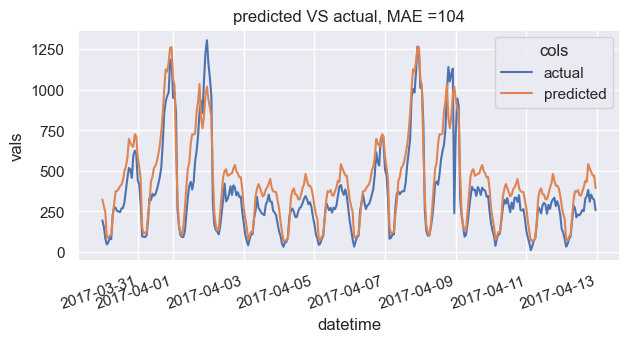

In [24]:
plot_predicted_vs_actual(df = df_actual_vs_pred,
                         fig_size = (7,3))

It appears that in terms of seasonality, baseline_a is catching the weekly and daily patterns. However, it is also clear that it tends to over-predict demands most of the time. The main reason for this is its lack of capturing the overall monthly trend. By taking a simple mean of hours and days of the last month, it completely ignores changes in trends in the new month. 

Another limitation of this baseline is its poor performance in predicting peaks and drops, which may be due to the following reasons: 
1. It completely ignores other features such as day types (holidays, etc.) 
2. It does not use daily/hourly trend features.

Ofcurse we can improve this baseline in terms of MAE by adding more features (As speciel days, trends etc) or simply grid search for better interval of lag history as shown in the following example.

In [25]:
from utils import plot_predicted_vs_actual_for_different_intervals

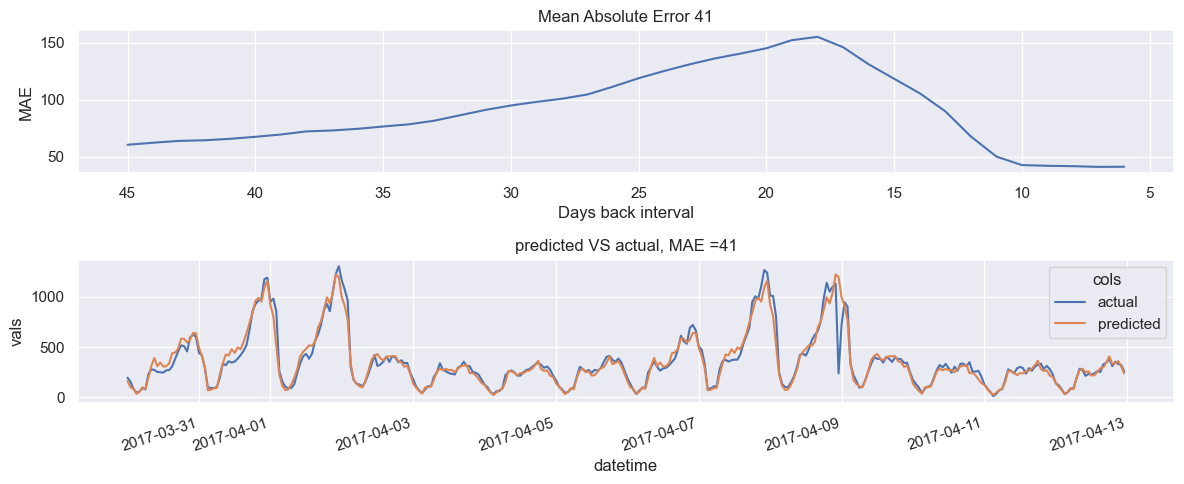

In [26]:
days_back_range = 46

best_mae = plot_predicted_vs_actual_for_different_intervals(df = df, 
                                                            test = test, 
                                                            days_back_range = days_back_range,
                                                            groupby_cols = ['weekday', 'hour'],
                                                            value_col = "rides")

In [27]:
best_mae

{'best_mae': 41.00297619047619, 'best_mae_interval': 8}

### Seconde baseline 

For the following baseline, in orther to generate predicrion for point $n$ we will average all previous $n-1$ to $n-k$ points. 

The assumptions for this are: 
1. there are k last points for all test points (no missing values or NaNs) 
2. Using all data up until the last hour is aligned with business logic, meaning that this short-term prediction is valuable for the business as it is able to act accordingly to this short-term. 

Here we will also be not use addtional features.

In [28]:
from utils import fit_predict_baseline_b

In [29]:
mae,df_actual_vs_pred = fit_predict_baseline_b(df = df, 
                                               df_predict = test, 
                                               k_last_hours = 4, 
                                               value_col = "rides")

mae

117.55803571428571

As same as before in order to take a closer look and to examine how we can improve th baseline we can gridsearch for different intervals 

In [30]:
from utils import plot_predicted_vs_actual_for_different_intervals_bl_b

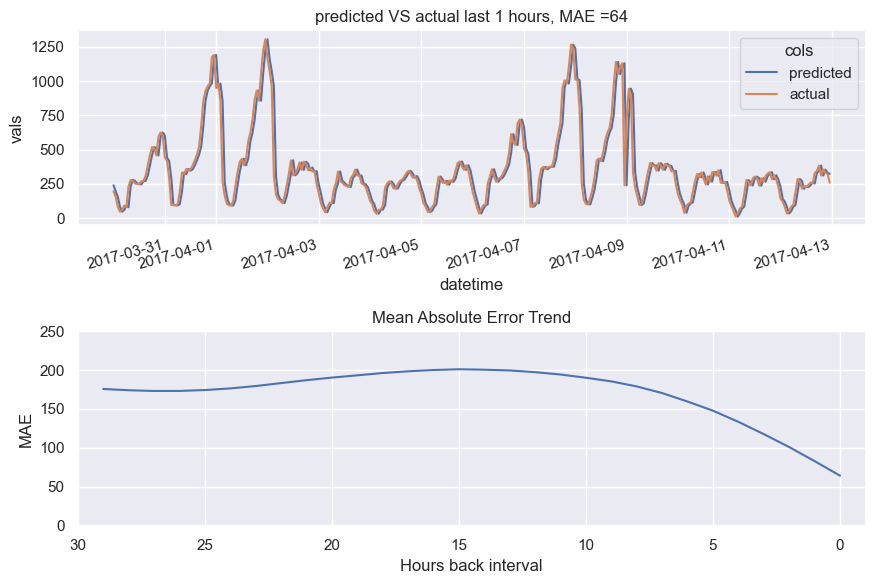

In [31]:
hours_back_range = 30
best_mae = plot_predicted_vs_actual_for_different_intervals_bl_b(df = df,
                                                                  test = test,
                                                                  hours_back_range = hours_back_range,
                                                                  value_col = "rides")

In [32]:
best_mae

{'best_mae': 64.05059523809524, 'best_mae_interval': 1}

As it clearly shown, for the given baseline technique, using the last hour value as predictor for the next hour error is minimal. 
But in many cases we are willing to generate predictions earlier, cause in reality there is many contraits that not allows to use so short time prediction.
For example, To move taxis between areas, like cities, in the morning of israel its impossible thing.

in case of missing values we need to think and recommand for techniques for imputing

### Task #6

Now let's create a model and calculate its performance.

Is it better than the baseline?

**Use the same test set from previous task**.

### Task #6 - Answer


Here we will target this section by two ways : 
1. A regulare mechine learning approach
2. Complex time series aprroch 

In [33]:
df = df_hourly_times_rides[:]

## Mechine learning approch

##### data_processing

Here we giving example for simole data proccsing. The following fucntion is : 
1. Calculate some new feautres, as:  rides for given lage back time , Average rides for given time period, The calculations is accuring dinamcly, meaning we can control hoe many features and the time intervals .
2.  Convert features to categoricl 
3. Remove Na from target variable.

In [36]:
from utils import data_processing

In [37]:
cat_cols = ['weekday','hour','us_holiday_type']
lag_features = [("h",1),("h",24),("d",2)]
avg_features =[(4,'h'),(8,'h')]

In [38]:
df = data_processing(df = df,
                     cat_cols = cat_cols,
                     value_column = 'rides',
                     lag_features = lag_features,
                     avg_features =avg_features)

### Train test split 

In [39]:
test = df[(df.datetime >= '2017-03-30 00:00:00') & (df.datetime < '2017-04-13 00:00:00')]
train = df[(df.datetime >= test.datetime.min() - pd.Timedelta(days=300)) &\
           (df.datetime < test.datetime.min())]

##### Choos features

Some of features Left out since they have no direct information which directly learnd by the model as thw datetime features. And some are not contribut the model in the current constelation, for example `weekofyear` and `dayofyear` cause we have data of onlt one year.
Obviously in futures iteration we can add, test and choos doffereant features by using smarter feature selections techniques (As looking into feature improtance, SHAP, or features weights)

In [41]:
y = 'rides'
X = ['weekday', 
     'us_holiday', 
     'us_holiday_type', 
     'hour',
     'rides',
     'rides_last_d_7',
     'rides_last_h_1',
     'rides_last_h_24',
     'rides_last_d_2', 
     'roll_avg_4h_', 
     'roll_avg_8h_']

##### Asing features and target columns 

In [42]:
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

### Fit model

In [47]:
from catboost import CatBoostRegressor

In [48]:
categorical_features_indices = ["weekday",'us_holiday_type','hour']

In [49]:
model = CatBoostRegressor()
# Fit model
model.fit(X_train, 
          y_train,
          cat_features=categorical_features_indices)

# Get predictions
y_train_pred = model.predict(X_train)

Learning rate set to 0.055606
0:	learn: 223.0065499	total: 60.3ms	remaining: 1m
1:	learn: 211.7588423	total: 63.8ms	remaining: 31.8s
2:	learn: 201.1709682	total: 67ms	remaining: 22.3s
3:	learn: 191.0591981	total: 70.2ms	remaining: 17.5s
4:	learn: 181.4728478	total: 73.5ms	remaining: 14.6s
5:	learn: 172.6441776	total: 76.5ms	remaining: 12.7s
6:	learn: 164.0363418	total: 79.3ms	remaining: 11.3s
7:	learn: 155.5953399	total: 81.8ms	remaining: 10.1s
8:	learn: 148.2163599	total: 84.5ms	remaining: 9.3s
9:	learn: 141.0453838	total: 87.2ms	remaining: 8.64s
10:	learn: 133.7669596	total: 89.7ms	remaining: 8.06s
11:	learn: 127.1423425	total: 92.2ms	remaining: 7.59s
12:	learn: 120.8798685	total: 94.7ms	remaining: 7.19s
13:	learn: 114.9576338	total: 97.2ms	remaining: 6.85s
14:	learn: 109.4469041	total: 99.9ms	remaining: 6.56s
15:	learn: 104.0534636	total: 103ms	remaining: 6.31s
16:	learn: 99.0397105	total: 105ms	remaining: 6.09s
17:	learn: 94.4314757	total: 108ms	remaining: 5.9s
18:	learn: 89.779259

225:	learn: 7.6162739	total: 583ms	remaining: 2s
226:	learn: 7.5855283	total: 585ms	remaining: 1.99s
227:	learn: 7.5587930	total: 588ms	remaining: 1.99s
228:	learn: 7.5291159	total: 590ms	remaining: 1.99s
229:	learn: 7.5173012	total: 592ms	remaining: 1.98s
230:	learn: 7.4944655	total: 594ms	remaining: 1.98s
231:	learn: 7.4832399	total: 597ms	remaining: 1.98s
232:	learn: 7.4725977	total: 599ms	remaining: 1.97s
233:	learn: 7.4625028	total: 600ms	remaining: 1.96s
234:	learn: 7.4380014	total: 603ms	remaining: 1.96s
235:	learn: 7.4241787	total: 605ms	remaining: 1.96s
236:	learn: 7.4191232	total: 607ms	remaining: 1.95s
237:	learn: 7.3976960	total: 609ms	remaining: 1.95s
238:	learn: 7.3739770	total: 611ms	remaining: 1.95s
239:	learn: 7.3643131	total: 613ms	remaining: 1.94s
240:	learn: 7.3426553	total: 616ms	remaining: 1.94s
241:	learn: 7.3366405	total: 618ms	remaining: 1.93s
242:	learn: 7.3157629	total: 620ms	remaining: 1.93s
243:	learn: 7.3045670	total: 621ms	remaining: 1.93s
244:	learn: 7.2

464:	learn: 4.5824227	total: 1.15s	remaining: 1.33s
465:	learn: 4.5765992	total: 1.16s	remaining: 1.32s
466:	learn: 4.5662754	total: 1.16s	remaining: 1.32s
467:	learn: 4.5607033	total: 1.16s	remaining: 1.32s
468:	learn: 4.5531346	total: 1.16s	remaining: 1.32s
469:	learn: 4.5479157	total: 1.17s	remaining: 1.31s
470:	learn: 4.5389895	total: 1.17s	remaining: 1.31s
471:	learn: 4.5318590	total: 1.17s	remaining: 1.31s
472:	learn: 4.5263374	total: 1.17s	remaining: 1.31s
473:	learn: 4.5188375	total: 1.18s	remaining: 1.3s
474:	learn: 4.5133713	total: 1.18s	remaining: 1.3s
475:	learn: 4.5066150	total: 1.18s	remaining: 1.3s
476:	learn: 4.5007345	total: 1.18s	remaining: 1.3s
477:	learn: 4.4948595	total: 1.18s	remaining: 1.29s
478:	learn: 4.4915949	total: 1.19s	remaining: 1.29s
479:	learn: 4.4860664	total: 1.19s	remaining: 1.29s
480:	learn: 4.4809176	total: 1.19s	remaining: 1.29s
481:	learn: 4.4767257	total: 1.19s	remaining: 1.28s
482:	learn: 4.4726828	total: 1.2s	remaining: 1.28s
483:	learn: 4.466

638:	learn: 3.6848547	total: 1.55s	remaining: 875ms
639:	learn: 3.6803760	total: 1.55s	remaining: 872ms
640:	learn: 3.6777751	total: 1.55s	remaining: 870ms
641:	learn: 3.6740803	total: 1.55s	remaining: 868ms
642:	learn: 3.6717196	total: 1.56s	remaining: 865ms
643:	learn: 3.6701265	total: 1.56s	remaining: 863ms
644:	learn: 3.6668998	total: 1.56s	remaining: 860ms
645:	learn: 3.6646647	total: 1.56s	remaining: 858ms
646:	learn: 3.6623708	total: 1.57s	remaining: 855ms
647:	learn: 3.6602009	total: 1.57s	remaining: 853ms
648:	learn: 3.6574482	total: 1.57s	remaining: 851ms
649:	learn: 3.6527790	total: 1.57s	remaining: 848ms
650:	learn: 3.6447525	total: 1.58s	remaining: 846ms
651:	learn: 3.6413193	total: 1.58s	remaining: 843ms
652:	learn: 3.6358129	total: 1.58s	remaining: 841ms
653:	learn: 3.6328328	total: 1.58s	remaining: 838ms
654:	learn: 3.6268969	total: 1.59s	remaining: 836ms
655:	learn: 3.6244098	total: 1.59s	remaining: 833ms
656:	learn: 3.6199504	total: 1.59s	remaining: 831ms
657:	learn: 

804:	learn: 3.1492811	total: 1.94s	remaining: 470ms
805:	learn: 3.1468896	total: 1.94s	remaining: 467ms
806:	learn: 3.1442509	total: 1.94s	remaining: 465ms
807:	learn: 3.1415386	total: 1.95s	remaining: 463ms
808:	learn: 3.1399277	total: 1.95s	remaining: 460ms
809:	learn: 3.1367462	total: 1.95s	remaining: 458ms
810:	learn: 3.1349472	total: 1.95s	remaining: 455ms
811:	learn: 3.1327157	total: 1.96s	remaining: 453ms
812:	learn: 3.1296053	total: 1.96s	remaining: 451ms
813:	learn: 3.1272104	total: 1.96s	remaining: 448ms
814:	learn: 3.1249507	total: 1.96s	remaining: 446ms
815:	learn: 3.1232292	total: 1.97s	remaining: 444ms
816:	learn: 3.1223589	total: 1.97s	remaining: 441ms
817:	learn: 3.1195650	total: 1.97s	remaining: 439ms
818:	learn: 3.1174134	total: 1.97s	remaining: 436ms
819:	learn: 3.1142594	total: 1.98s	remaining: 434ms
820:	learn: 3.1110951	total: 1.98s	remaining: 431ms
821:	learn: 3.1076750	total: 1.98s	remaining: 429ms
822:	learn: 3.1043990	total: 1.98s	remaining: 427ms
823:	learn: 

968:	learn: 2.7887747	total: 2.33s	remaining: 74.4ms
969:	learn: 2.7878896	total: 2.33s	remaining: 72ms
970:	learn: 2.7864631	total: 2.33s	remaining: 69.6ms
971:	learn: 2.7849371	total: 2.33s	remaining: 67.2ms
972:	learn: 2.7811262	total: 2.34s	remaining: 64.8ms
973:	learn: 2.7792872	total: 2.34s	remaining: 62.4ms
974:	learn: 2.7774600	total: 2.34s	remaining: 60.1ms
975:	learn: 2.7756829	total: 2.34s	remaining: 57.6ms
976:	learn: 2.7746809	total: 2.35s	remaining: 55.2ms
977:	learn: 2.7713406	total: 2.35s	remaining: 52.8ms
978:	learn: 2.7693774	total: 2.35s	remaining: 50.5ms
979:	learn: 2.7668816	total: 2.35s	remaining: 48ms
980:	learn: 2.7641825	total: 2.36s	remaining: 45.6ms
981:	learn: 2.7591516	total: 2.36s	remaining: 43.2ms
982:	learn: 2.7569156	total: 2.36s	remaining: 40.8ms
983:	learn: 2.7542851	total: 2.36s	remaining: 38.4ms
984:	learn: 2.7527282	total: 2.37s	remaining: 36ms
985:	learn: 2.7516772	total: 2.37s	remaining: 33.6ms
986:	learn: 2.7494671	total: 2.37s	remaining: 31.2ms

In [50]:
mean_absolute_error(y_train_pred, y_train)

1.7844226485275418

# Seconde approche - Time series approch

In this aproch we would use methods which are build to case of sequence modeling.
That kinf of approchase should reduce the need of feature engineering, because they trying to estimating the directly out of the sequential data.
Here we would give an example of using Vanila LSTM. Ofcurse that for much long term research we ould my interested in search for more specific archotectures, parameters or even more sdvance model as `neuralprophet`.

In [481]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [482]:
df_lstm = df_hourly_times_rides[["rides"]][:]

### Task #7

You've been offered to purchase an extension of this historical dataset going further into the past. In order to decide whether it is worthwhile, you need to estimate if there's a potential to improve the model given this data.

What is your estimation and why?

#### Answer 
A good approch to decide if addtional data can contribute to our performance is to take a look on the trend of performance with respect to to past interval.
So lets returning the above with several interval and present the results 

In [51]:
from tqdm import tqdm


In [55]:
mae_history = []
for back_interval in tqdm(range(10,train.shape[0],60)):

    train_i = train[(train.datetime >= test.datetime.min() - pd.Timedelta(days=back_interval)) &\
                    (train.datetime < test.datetime.min())]



    X_train = train_i[X]
    y_train = train_i[y]
    X_test = test[X]
    y_test = test[y]

    model = CatBoostRegressor()
    model.fit(X_train, 
              y_train,
              cat_features=categorical_features_indices,
              verbose=False)

    y_train_pred = model.predict(X_train)

    y_test_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test_pred, y_test)

    mae_history.append(mae)


100%|█████████████████████████████████████████| 116/116 [05:17<00:00,  2.74s/it]


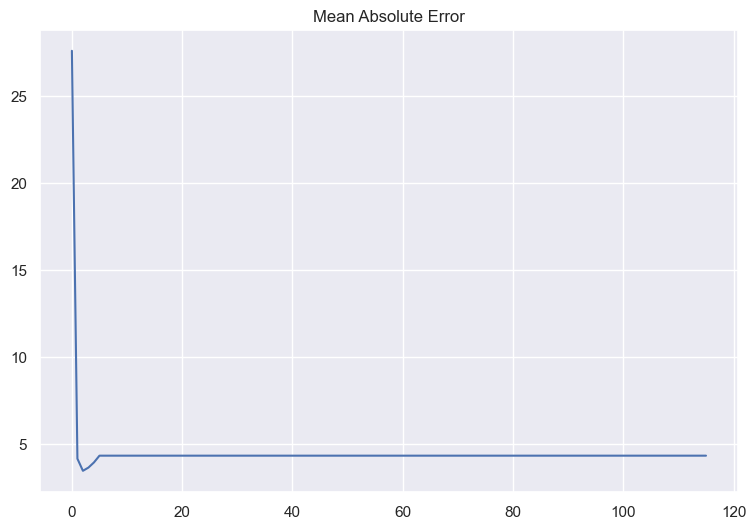

In [56]:
fig, ax =plt.subplots(1,1)
ax.plot(mae_history)
ax.set_title("Mean Absolute Error")
plt.show()

As it easy to see after lag back of arounf 30-20 days, there is no sagnificant impact of extension the data back in terms of test performance.

# --------- LSTM

In [597]:
df_daily_rides[df_daily_rides.rides]

KeyError: "None of [Int64Index([    7,    13,    24,    22,    39,    59,    54,    53,    19,\n               19,\n            ...\n             5140,  5918,  8065, 13003, 14068,  9003,  5589,  5165,  5403,\n             4573],\n           dtype='int64', length=314)] are in the [columns]"

In [537]:
df_lstm = df_hourly_times_rides[["rides"]][:]
df = df_hourly_times_rides[:]

In [540]:
df_lstm = df_lstm[~df_lstm.rides.isna()]
df = df[~df.rides.isna()]

In [541]:
# fix random seed for reproducibility
tf.random.set_seed(7)
dataset = df_lstm.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)




In [542]:
test =  dataset[(df.datetime >= min_datetetime) & (df.datetime < '2017-04-13 00:00:00')]
train = dataset[(df.datetime >= pd.to_datetime(min_datetetime) - pd.Timedelta(days=300)) &\
                (df.datetime < min_datetetime)]

In [544]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [545]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [546]:
# create and fit the LSTM network
input_dim = 1
model = Sequential()
model.add(LSTM(4, input_shape=(1, input_dim)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2,validation_split=0.1,)

Epoch 1/5
6245/6245 - 7s - loss: 0.0026 - val_loss: 0.0022 - 7s/epoch - 1ms/step
Epoch 2/5
6245/6245 - 5s - loss: 8.8471e-04 - val_loss: 0.0022 - 5s/epoch - 856us/step
Epoch 3/5
6245/6245 - 5s - loss: 8.7731e-04 - val_loss: 0.0022 - 5s/epoch - 876us/step
Epoch 4/5
6245/6245 - 6s - loss: 8.8032e-04 - val_loss: 0.0023 - 6s/epoch - 889us/step
Epoch 5/5
6245/6245 - 5s - loss: 8.7713e-04 - val_loss: 0.0022 - 5s/epoch - 855us/step


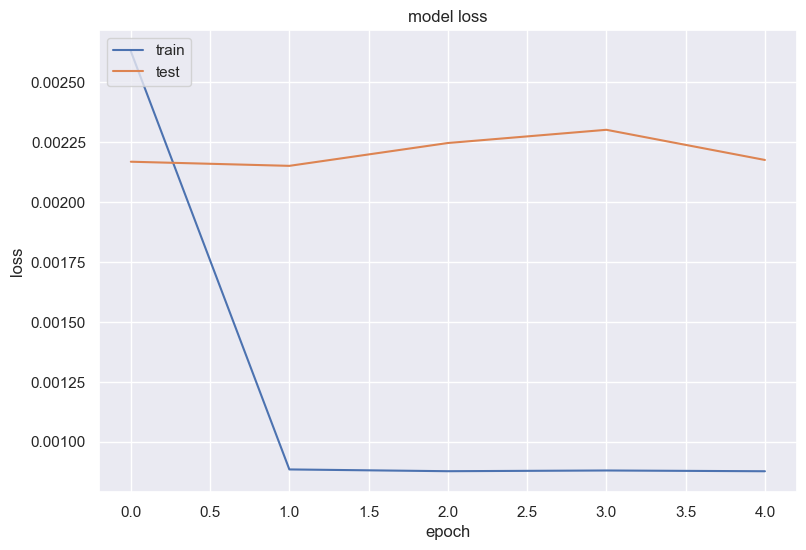

In [547]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [548]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

11/11 [==============================] - 0s 890us/step


In [549]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [550]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [551]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 74.42 RMSE
Test Score: 108.97 RMSE


In [552]:

mean_absolute_error(testY[0], testPredict[:,0])

64.5227475184198

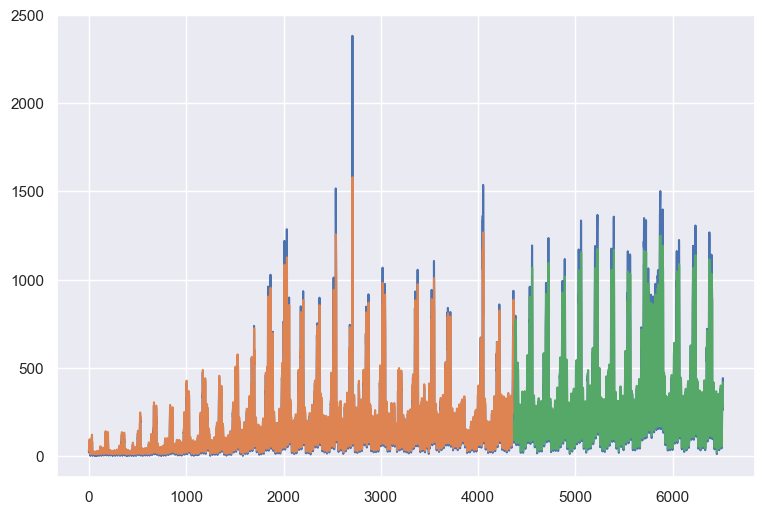

In [480]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()